# 📊 Enrichment Overview and HTML Preview

In [31]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

load_dotenv()
engine = create_engine(os.getenv("POSTGRES_URL"))


## Load Tables

In [32]:
nodes_df = pd.read_sql("SELECT * FROM nodes", engine)
meta_df = pd.read_sql("SELECT * FROM metadata", engine)
df = nodes_df.merge(meta_df, on="ott_id", how="left")


## Metadata Enrichment Stats

In [33]:
total_nodes = len(nodes_df)
total_enriched = len(meta_df)
with_images = meta_df['image_url'].notna().sum()
with_desc = meta_df['description'].notna().sum()
with_page = meta_df['wiki_page_url'].notna().sum()

print(f"Enriched: {total_enriched:,} / {total_nodes:,}")
print(f"With images: {with_images:,}")
print(f"With descriptions: {with_desc:,}")
print(f"With Wikipedia pages: {with_page:,}")


Enriched: 2,272 / 2,870,658
With images: 256
With descriptions: 2,231
With Wikipedia pages: 473


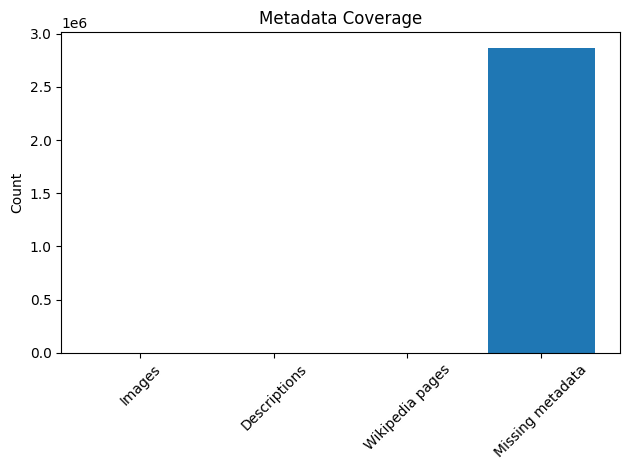

In [34]:
import matplotlib.pyplot as plt

counts = {
    "Images": with_images,
    "Descriptions": with_desc,
    "Wikipedia pages": with_page,
    "Missing metadata": total_nodes - total_enriched
}

plt.bar(counts.keys(), counts.values())
plt.ylabel("Count")
plt.title("Metadata Coverage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## HTML Preview of Enriched Taxa

In [35]:
from IPython.display import display, HTML

# Filter rows that have BOTH image and full description
preview_df = df[
    df["image_url"].notna() &
    df["full_description"].notna()
].copy()

# Wikipedia link icon
preview_df["link"] = preview_df["wiki_page_url"].apply(
    lambda url: f'<a href="{url}" target="_blank">🔗</a>' if pd.notna(url) else ""
)

# Clickable thumbnail image
preview_df["image"] = preview_df["image_url"].apply(
    lambda url: f'<a href="{url}" target="_blank"><img src="{url}" width="60"></a>' if pd.notna(url) else ""
)

# Columns to display
cols = [
    "image",
    "ott_id",
    "name",
    "common_name",
    "rank",
    "enriched_score",
    "full_description",
    "link"
]

html = preview_df[cols].sample(n=min(10, len(preview_df))).to_html(escape=False, index=False)
display(HTML(html))

image,ott_id,name,common_name,rank,enriched_score,full_description,link
,2900356,Columbella strombiformis,Columbella strombiformis,species,1.0,"Columbella strombiformis, common name stromboid dove shell, is a species of sea snail, a marine gastropod mollusk in the family Columbellidae, the dove snails.",🔗
,1064124,Polypterus senegalus,Polypterus senegalus,species,1.0,"Polypterus senegalus, commonly known as the Senegal bichir, gray bichir or Cuvier's bichir, is an African species of ray-finned fish in the bichir family, Polypteridae. It is a typical example of polypterid fishes, as most of its defining physical features are common across the genus, such as its ancient, lungfish- or arowana-like appearance, the ability to breathe atmospheric oxygen, and its armor-like scales. These factors have influenced the species' popularity in captivity, and it is commonly kept by aquarists and other hobbyists. P. senegalus is sometimes, confusingly, called the ""dinosaur eel"" or ""dragon fish"", among other misnomers; however, the bichir is not an eel, nor is it a reptile or dinosaur.",🔗
,2874986,Ancula lentiginosa,Ancula lentiginosa,species,1.0,"Ancula lentiginosa is a species of sea slug, a dorid nudibranch, a marine gastropod mollusc in the family Goniodorididae.",🔗
,1023130,Psilopsiagon aurifrons,Mountain Parakeet,species,1.0,"The mountain parakeet (Psilopsiagon aurifrons), also known as the golden-fronted parakeet, is a species of parrot, one of two in the genus Psilopsiagon within the family Psittacidae. It is found in the Puna grassland. Its natural habitat is subtropical or tropical high-altitude shrubland. Four subspecies are recognised.",🔗
,247369,Sundadanio axelrodi,Sundadanio axelrodi,species,1.0,"Sundadanio axelrodi is a species of freshwater ray-finned fish belonging to the family Sundadanionidae, the tiny danios. This fish is known only from Bintan Island in the Riau Islands east of Sumatra. Originally described as a rasbora, Rasbora axelrodi, this tiny species was later deemed to be more closely related to the danios but not enough to be moved into the genus Danio. Sundadanio axelrodi reaches a maximum size of 1.7 cm. Sundadanio was considered monotypic until the genus was reassessed by Conway, Kottelat and Tan in 2011.",🔗
,6290770,Necroraphidia,Necroraphidia,genus,1.0,"Necroraphidia is an extinct genus of snakefly in the family Mesoraphidiidae. The genus is solely known from Early Cretaceous, Albian age, fossil amber found in Spain. Currently the genus comprises a single species, Necroraphidia arcuata.",🔗
,3598040,Urocissa ornata,Sri Lanka Blue Magpie,species,1.0,"The Sri Lanka blue magpie or Ceylon magpie (Urocissa ornata) is a brightly coloured member of the family Corvidae, found exclusively in Sri Lanka. This species is adapted to hunting in the dense canopy, where it is highly active and nimble. Its flight is rather weak, though, and is rarely used to cover great distances. In spite of the Sri Lanka blue magpie's ability to adapt to the presence of humans, it is classified as vulnerable to extinction due to the fragmentation and destruction of its habitat of dense primary forest in the wet zone of southern Sri Lanka.",🔗
,3233543,Tortilia,Tortilia,genus,1.0,Tortilia is a genus of moths in the Stathmopodidae family.,🔗
,53344,Coptotermes gestroi,Coptotermes gestroi,species,1.0,"Coptotermes gestroi, commonly known as the Asian subterranean termite is a small species of termite that lives underground. Both this species and the Formosan subterranean termite (Coptotermes formosanus) are destructive pests native to Asia, but have spread to other parts of the world including the United States. In Asia, this species is known as the Philippine milk termite. The termite species Coptotermes havilandi was determined by Kirton and Brown in 2003 to be identical to Coptotermes gestroi, so following the principle of priority, the older name is now used.",🔗
,951132,Selasphorus sasin,Allen's Hummingbird,species,1.0,Allen's hummingbird 